In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle

from collections import Counter
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.layers import SimpleRNN, Embedding, Dense, LSTM
from keras.models import Sequential, load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

import utils

import warnings
warnings.filterwarnings('ignore')

np.random.seed(1)

Using TensorFlow backend.


Mengambil ```data.csv``` dari direktori ```Dataset/``` yang berisi kumpulan data kalimat umpatan.

In [2]:
data = pd.read_csv('Dataset/data.csv')

Medefinisikan target kelas atau label pada data ```{0: Bukan-Umpatan, 1: Umpatan}```.

In [3]:
classes = ['Non-Offensive', 'Offensive']

In [4]:
data.head()

Text  Label
0  kalo gila jangan keterlaluan apa      1
1     gila banget sih lu jadi orang      1
2               ente ente yang gila      1
3                       budek lu ya      1
4                  jangan gitu nyet      1

In [5]:
def preprocessing(text):
    stopword = StopWordRemoverFactory().create_stop_word_remover()
    stemmer = StemmerFactory().create_stemmer()
    
    text = text.lower()
    text = re.sub(r' +', ' ', text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]',' ', text)
    
    text = stopword.remove(text)
    text = stemmer.stem(text)
    
    return text

In [6]:
data["Cleaned_Text"] = data["Text"].map(preprocessing)

In [7]:
data.head()

Text  Label                   Cleaned_Text
0  kalo gila jangan keterlaluan apa      1   kalo gila jangan terlalu apa
1     gila banget sih lu jadi orang      1  gila banget sih lu jadi orang
2               ente ente yang gila      1                 ente ente gila
3                       budek lu ya      1                       budek lu
4                  jangan gitu nyet      1               jangan gitu nyet

In [8]:
X = data['Cleaned_Text'].values
y = data['Label'].values

In [9]:
def word_cloud(data, label, title):
    a = ' '.join(list(data[data['Label'] == label]['Cleaned_Text']))
    b = WordCloud(width = 512, height = 512, background_color="white").generate(a)
    plt.figure(figsize = (5, 4))
    plt.imshow(b)
    plt.title(title)
    plt.axis('off')
    plt.tight_layout(pad = 0)
    plt.show()

Menampilkan data yang dominan di tiap target kelas.

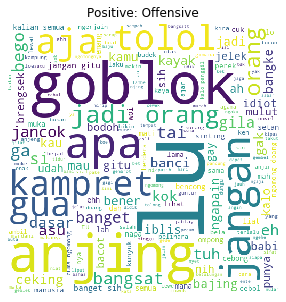

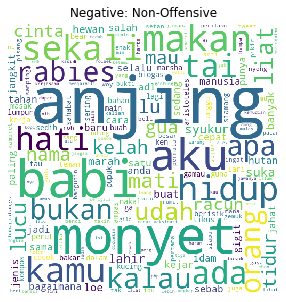

In [10]:
word_cloud(data, 1, 'Positive: Offensive')
word_cloud(data, 0, 'Negative: Non-Offensive')

Mengubah setiap sampel data yang berupa kata atau kumpulan kata menjadi array yang berisi angka numerik.

In [11]:
tokenizer = Tokenizer()   
tokenizer.fit_on_texts(X)

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
def preprocessing(tokenizer, texts, maxlen=40):
    sequences = tokenizer.texts_to_sequences(texts)
    data = pad_sequences(sequences, maxlen=maxlen)
    
    return data

In [13]:
X_data = preprocessing(tokenizer, X)

Mebagi data menjadi data pelatihan dan pengujian.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size=0.1, random_state=3)

**Pemodelan Reccurent Neural Network (RNN)**

In [15]:
model = Sequential()
model.add(Embedding(np.max(X_data)+1, 64))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

model.summary()

W0715 03:56:22.029441 139812228441920 deprecation_wrapper.py:119] From /home/hssahrul/miniconda3/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0715 03:56:22.056777 139812228441920 deprecation_wrapper.py:119] From /home/hssahrul/miniconda3/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0715 03:56:22.062750 139812228441920 deprecation_wrapper.py:119] From /home/hssahrul/miniconda3/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0715 03:56:22.288558 139812228441920 deprecation_wrapper.py:119] From /home/hssahrul/miniconda3/envs/ML/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          42816     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                3104      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 45,953
Trainable params: 45,953
Non-trainable params: 0
_________________________________________________________________


In [16]:
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True, baseline=0.95)

In [17]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=[es])

W0715 03:56:23.084139 139812228441920 deprecation_wrapper.py:119] From /home/hssahrul/miniconda3/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 361 samples, validate on 91 samples
Epoch 1/100
361/361 [==============================] - 1s 3ms/step - loss: 0.4725 - acc: 0.8144 - val_loss: 0.3806 - val_acc: 0.8681
Epoch 2/100
361/361 [==============================] - 0s 514us/step - loss: 0.3997 - acc: 0.8366 - val_loss: 0.3617 - val_acc: 0.8681
Epoch 3/100
361/361 [==============================] - 0s 544us/step - loss: 0.3483 - acc: 0.8393 - val_loss: 0.3506 - val_acc: 0.8681
Epoch 4/100
361/361 [==============================] - 0s 547us/step - loss: 0.2837 - acc: 0.8643 - val_loss: 0.3053 - val_acc: 0.8681
Epoch 5/100
361/361 [==============================] - 0s 539us/step - loss: 0.2052 - acc: 0.9280 - val_loss: 0.2576 - val_acc: 0.8901
Epoch 6/100
361/361 [==============================] - 0s 516us/step - loss: 0.1458 - acc: 0.9612 - val_loss: 0.2117 - val_acc: 0.9121
Epoch 7/100
361/361 [==============================] - 0s 570us/step - loss: 0.1023 - acc: 0.9834 - val_loss: 0.1785 - val_acc: 0.9560
Epoch 8/100


Melakukan evaluasi terhadap performa model RNN.

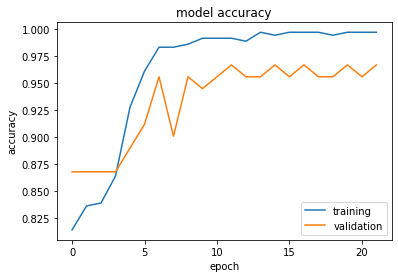

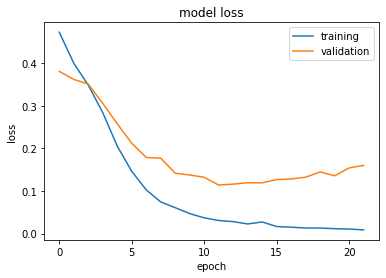

In [18]:
utils.plot_accuracy(history)
utils.plot_loss(history)

Kemampuan model untuk melakukan generalisasi pada data pengujian.

In [19]:
loss, acc = model.evaluate(X_test, y_test)
print('Loss: {:.2f}, Acc: {:.2f}'.format(loss, acc))

51/51 [==============================] - 0s 346us/step
Loss: 0.22, Acc: 0.92


In [20]:
y_pred = model.predict_classes(X_test)

In [21]:
confusion_matrix(y_test, y_pred)

array([[ 8,  4],
       [ 0, 39]])

In [22]:
y_pred = y_pred.reshape(51,)

df_y_cls = [classes[i] for i in y_test]
df_p_cls = [classes[j] for j in y_pred]

Menampilkan beberapa sampel data dan hasil prediksi dari model.

In [23]:
# df_x = pd.DataFrame(X_test, columns=['Text'])
# df_y = pd.DataFrame(df_y_cls, columns=['Actual'])
# df_p = pd.DataFrame(df_p_cls , columns=['Predict'])

# df_res = pd.concat([data['Cleaned_Text'], df_y, df_p], axis=1)

# df_res.head(10)

Train seluruh data set.

In [24]:
history = model.fit(X_data, y, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=[es])

Train on 402 samples, validate on 101 samples
Epoch 1/100
402/402 [==============================] - 0s 558us/step - loss: 0.0674 - acc: 0.9701 - val_loss: 0.0881 - val_acc: 0.9703
Epoch 2/100
402/402 [==============================] - 0s 473us/step - loss: 0.0361 - acc: 0.9900 - val_loss: 0.0806 - val_acc: 0.9703
Epoch 3/100
402/402 [==============================] - 0s 501us/step - loss: 0.0280 - acc: 0.9925 - val_loss: 0.0801 - val_acc: 0.9703
Epoch 4/100
402/402 [==============================] - 0s 465us/step - loss: 0.0207 - acc: 0.9950 - val_loss: 0.0762 - val_acc: 0.9703
Epoch 5/100
402/402 [==============================] - 0s 500us/step - loss: 0.0185 - acc: 0.9975 - val_loss: 0.0820 - val_acc: 0.9703
Epoch 6/100
402/402 [==============================] - 0s 513us/step - loss: 0.0156 - acc: 0.9950 - val_loss: 0.0882 - val_acc: 0.9703
Epoch 7/100
402/402 [==============================] - 0s 535us/step - loss: 0.0114 - acc: 1.0000 - val_loss: 0.0900 - val_acc: 0.9703
Epoch 8/1

In [25]:
model.save('Model/Model-Iterasi-2.h5')

Melakukan prediksi pada data yang tidak pernah dilihat model.

In [26]:
unseen_text = ['aku baik-baik saja']

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

sequences = tokenizer.texts_to_sequences(unseen_text)
unseen_text = pad_sequences(sequences, maxlen=40)

print('Predict: {} | Confidence: {:.2f}'.format(classes[model.predict_classes(unseen_text)[0][0]], 
                                          model.predict(unseen_text)[0][0]))

Predict: Non-Offensive | Confidence: 0.03


Menggunakan model yang sudah di-train sebelumnya.

In [27]:
loaded_model = load_model('Model/Model-Iterasi-2.h5')

In [28]:
print('Predict: {} | Confidence: {:.2f}'.format(classes[loaded_model.predict_classes(unseen_text)[0][0]], 
                                          loaded_model.predict(unseen_text)[0][0]))

Predict: Non-Offensive | Confidence: 0.03
